In [26]:
import sys
sys.path.append("../")

import jax
import jax.numpy as np
import optax
import flax
from flax.core import FrozenDict

import tensorflow as tf
import tensorflow_datasets as tfds

# Ensure TF does not see GPU and grab all GPU memory
tf.config.set_visible_devices([], device_type='GPU')

from tqdm import tqdm, trange

replicate = flax.jax_utils.replicate
unreplicate = flax.jax_utils.unreplicate

from models.diffusion import VariationalDiffusionModel
from models.diffusion_utils import loss_vdm
from models.train_utils import create_input_iter, param_count, StateStore, train_step

from jetnet.datasets import JetNet, TopTagging

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
num_particles = 150

particle_data, jet_data = JetNet.getData(jet_type=["q"], data_dir="../data/", num_particles=num_particles)

EPS = 1e-7

jet_data_mean = jet_data.mean(axis=(0,))
jet_data_std = jet_data.std(axis=(0,))
jet_data = (jet_data - jet_data_mean) / (jet_data_std + EPS)

particle_mask = particle_data[:, :, -1]
particle_data = particle_data[:, :, :3]

In [28]:
batch_size = 64 * jax.device_count()
n_train = len(particle_data)

train_ds = tf.data.Dataset.from_tensor_slices((particle_data, jet_data, particle_mask))
train_ds = train_ds.cache()
train_ds = train_ds.repeat()

batch_dims=[jax.local_device_count(), batch_size // jax.device_count()]

for batch_size in reversed(batch_dims):
      train_ds = train_ds.batch(batch_size, drop_remainder=False)

train_ds = train_ds.shuffle(n_train)
train_df = create_input_iter(train_ds)

In [33]:
transformer_dict = FrozenDict({"d_model":256, "d_mlp":512, "n_layers":6, "n_heads":4, "flash_attention":True})

vdm = VariationalDiffusionModel(gamma_min=-6.0, 
          gamma_max=6.0, 
          n_layers=2, 
          embedding_dim=10,
          encoding_hidden_dim=128,
          timesteps=500, 
          feature_dim=3,
          latent_diffusion=True,
          transformer_dict=transformer_dict)

In [34]:
n_smoke = 4
batch = np.array(particle_data[:n_smoke])
conditioning = np.zeros((n_smoke, jet_data.shape[-1]))
mask = np.array(particle_mask[:n_smoke])

In [35]:
rng = jax.random.PRNGKey(42)
out, params = vdm.init_with_output({"sample": rng, "params": rng}, batch, conditioning, mask);

In [36]:
print(f"Params: {param_count(params):,}")

Params: 3,720,823


../models/train_utils.py:44: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  return sum(x.size for x in jax.tree_leaves(pytree))


In [37]:
train_steps = 120_000 // jax.device_count()

opt = optax.chain(
    optax.scale_by_schedule(optax.cosine_decay_schedule(1.0, train_steps, 1e-5)),
    optax.adamw(8e-4, weight_decay=1e-4),
    optax.scale_by_schedule(optax.linear_schedule(0.0, 1.0, 5000)))

store = StateStore(params, opt.init(params), rng, 0)
pstore = replicate(store)

In [38]:
batches = create_input_iter(train_ds)

vals = []
with trange(train_steps) as t:
  for i in t:
    pstore, val = train_step(pstore, loss_vdm, vdm, next(batches), opt)
    v = unreplicate(val)
    t.set_postfix(val=v)
    vals.append(v)

100%|██████████| 30000/30000 [17:41<00:00, 28.25it/s, val=-3.1772137]   


In [39]:
from models.diffusion_utils import sigma2

In [40]:
def generate(vdm, params, rng, shape, conditioning, mask=None, guidance_weight=0.0):
  # first generate latent
  rng, spl = jax.random.split(rng)
  zt = jax.random.normal(spl, shape + (vdm.embedding_dim,))

  def body_fn(i, z_t):
    return vdm.apply(
        params,
        rng,
        i,
        vdm.timesteps,
        z_t,
        conditioning,
        mask=None, 
        guidance_weight=guidance_weight,
        method=vdm.sample_step)
  
  z0 = jax.lax.fori_loop(
      lower=0, upper=vdm.timesteps, body_fun=body_fn, init_val=zt)
  g0 = vdm.apply(params, 0.0, method=vdm.gammat)
  var0 = sigma2(g0)
  z0_rescaled = z0 / np.sqrt(1. - var0)
  return vdm.apply(params, z0_rescaled, conditioning, method=vdm.decode)

In [41]:
import numpy as vnp

n_samples = 1000
idx_rnd = vnp.random.choice(vnp.arange(len(jet_data)), size=n_samples, replace=False)

cond = jet_data[idx_rnd]
mask = particle_mask[idx_rnd]
x_samples = generate(vdm, unreplicate(pstore).params, rng, (n_samples, num_particles), cond, mask=mask, guidance_weight=0.)
x_samples = x_samples.mean() * mask[:, :, None]

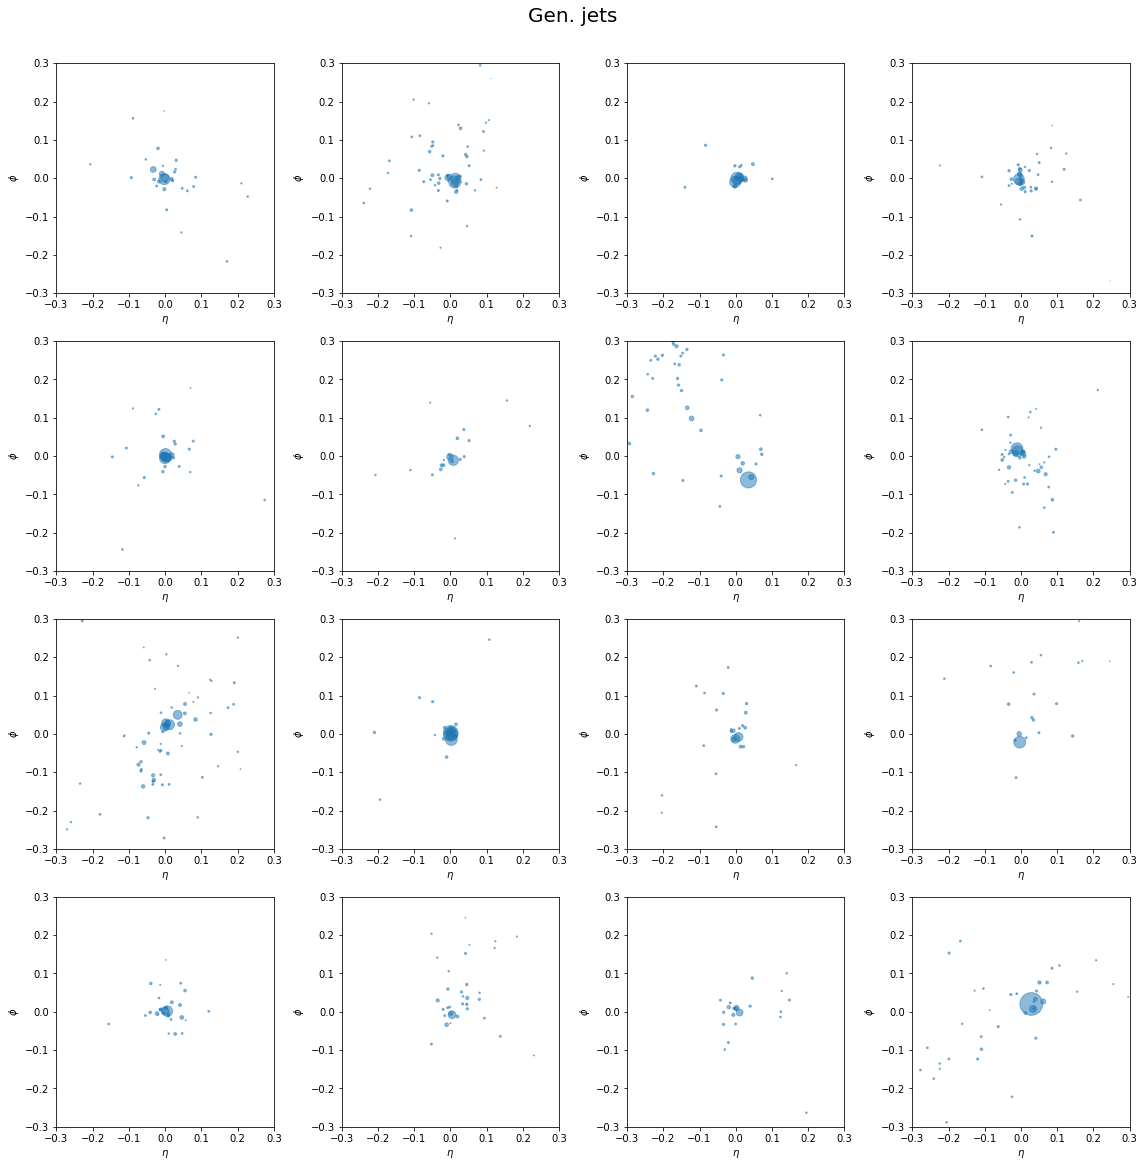

In [42]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(16, 16))
gs = GridSpec(4, 4)

for i in range(16):
    
    ax = fig.add_subplot(gs[i])
    
    ax.scatter(*x_samples[i, :, :2].T, s=1000 * (x_samples[i, :, 2]), alpha=0.5)
            
    ax.set_xlabel(r"$\eta$")
    ax.set_ylabel(r"$\phi$")
    
    ax.set_xlim(-0.3, 0.3)
    ax.set_ylim(-0.3, 0.3)
    
plt.suptitle("Gen. jets", fontsize=20, y=1.01)
plt.tight_layout()

In [43]:
idx_rnd = vnp.random.choice(vnp.arange(len(jet_data)), size=n_samples, replace=False)
x = particle_data[idx_rnd] * particle_mask[idx_rnd, :, None]

In [44]:
x_samples = x_samples.at[x_samples == 0.].set(-999.)
x[x == 0.] = -999.

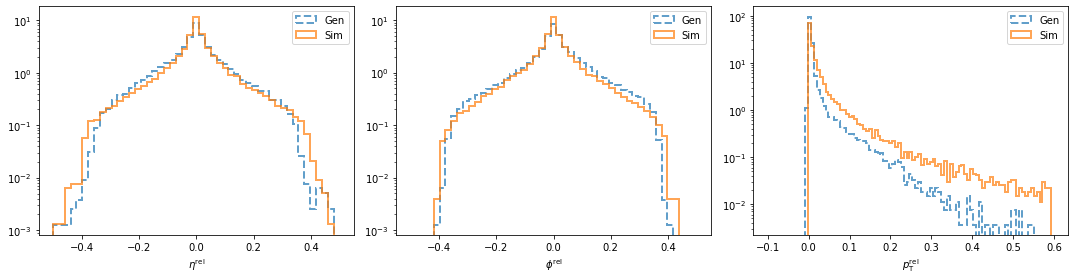

In [45]:
fig = plt.figure(figsize=(20, 4))
gs = GridSpec(1, 4)

#####

ax = fig.add_subplot(gs[0])

i_feat = 0

bins= np.linspace(-0.5, 0.5, 50)
ax.hist((np.concatenate(x_samples))[:, i_feat], histtype='step', bins=bins, density=True, lw=2, ls='--', alpha=0.7, label='Gen');

eta = np.concatenate((np.array(x)))[:, i_feat]
eta = eta[eta != 0.]
ax.hist(eta, histtype='step', density=True, bins=bins, lw=2, alpha=0.7, label='Sim');

ax.set_xlabel(r"$\eta^\mathrm{rel}$")
ax.get_yaxis().set_ticklabels([])

ax.set_yscale("log")

ax.legend()

#####

ax = fig.add_subplot(gs[1])

i_feat = 1

bins= np.linspace(-0.5, 0.5, 50)
ax.hist((np.concatenate(x_samples))[:, i_feat], histtype='step', bins=bins, density=True, lw=2, ls='--', alpha=0.7, label='Gen');

eta = (np.concatenate(np.array(x)))[:, i_feat]
eta = eta[eta != 0.]
ax.hist(eta, histtype='step', density=True, bins=bins, lw=2, alpha=0.7, label='Sim');

ax.set_xlabel(r"$\phi^\mathrm{rel}$")
ax.get_yaxis().set_ticklabels([])

ax.set_yscale("log")

ax.legend()

#####

ax = fig.add_subplot(gs[2])

i_feat = 2

bins= np.linspace(-0.1, 0.6, 100)
ax.hist((np.concatenate(x_samples))[:, i_feat], histtype='step', bins=bins, density=True, lw=2, ls='--', alpha=0.7, label='Gen');

eta = np.concatenate((np.array(x)))[:, i_feat]
eta = eta[eta != 0.]
ax.hist(eta, histtype='step', density=True, bins=bins, lw=2, alpha=0.7, label='Sim');

ax.set_xlabel(r"$p_\mathrm{T}^\mathrm{rel}$")
ax.get_yaxis().set_ticklabels([])
ax.legend()

ax.set_yscale("log")

ax.legend()

plt.tight_layout()